# Topic Modeling — Text Files

In these lessons, we're learning about a text analysis method called *topic modeling*. This method will help us identify the main topics or discourses within a collection of texts or single text that has been separated into smaller text chunks.

___

## Dataset

### *New York Times* Obituaries

```{epigraph}
 Georgia O'Keeffe, the undisputed doyenne of American painting and a leader, with her husband, Alfred Stieglitz, of a crucial phase in the development and dissemination of American modernism, died yesterday at St. Vincent Hospital in Santa Fe, N.M.

--  Edith Evans Asbury, [Georgia O'Keefe Dead At 98](https://www.nytimes.com/1986/03/07/obituaries/georgia-o-keeffe-dead-at-98-shaper-of-modern-art-in-us.html)
```

In this particular lesson, we're going to use [Little MALLET Wrapper](https://github.com/maria-antoniak/little-mallet-wrapper), a Python wrapper for [MALLET](http://mallet.cs.umass.edu/topics.php), to topic model 378 obituaries published by *The New York Times*. This dataset is based on data originally collected by Matt Lavin for his *Programming Historian* [TF-IDF tutorial](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf#lesson-dataset). I have re-scraped the obituaries so that the subject's name and death year is included in each text file name, and I have added 13 more ["Overlooked"](https://www.nytimes.com/interactive/2018/obituaries/overlooked.html) obituaries, including [Karen Spärck Jones](https://www.nytimes.com/2019/01/02/obituaries/karen-sparck-jones-overlooked.html), the computer scientist who introduced TF-IDF.

___

## Set MALLET Path

```{attention}
If you're working in this Jupyter notebook on your own computer, you'll need to have both the Java Development Kit and MALLET pre-installed. For set up instructions, please see [the previous lesson](http://melaniewalsh.github.io/Intro-Cultural-Analytics/Text-Analysis/Topic-Modeling-Set-Up.html).

If you're working in this Jupyter notebook in the cloud, then the Java Development Kit and Mallet will already be installed.
```

Since Little MALLET Wrapper is a Python package built around MALLET, we first need to tell it where the bigger, Java-based MALLET lives.

We're going to make a variable called `path_to_mallet` and assign it the file path of our MALLET program. We need to point it, specifically, to the "mallet" file inside the "bin" folder inside the "mallet-2.0.8" folder. 

In [14]:
path_to_mallet = 'mallet-2.0.8/bin/mallet'

If MALLET is located in another directory, then set your `path_to_mallet` to that file path.

## Install Packages

In [ ]:
#!pip install little_mallet_wrapper
#!pip install seaborn
#To install the most updated version of little_mallet_wrapper:
#!!pip install git+https://github.com/maria-antoniak/little-mallet-wrapper.git

## Import Packages

In [ ]:
#!pip install little_mallet_wrapper
#!pip install seaborn

Now let's `import` the `little_mallet_wrapper` and the data viz library `seaborn`.

In [2]:
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path

We're also going to import [`glob`](https://docs.python.org/3/library/glob.html) and [`pathlib`](https://docs.python.org/3/library/pathlib.html#basic-use) for working with files and the file system.

## Get Training Data From Text Files

Before we topic model the *NYT* obituaries, we need to process the text files and prepare them for analysis. The steps below demonstrate how to process texts if your corpus is a collection of separate text files. In the next lesson, we'll demonstrate how to process texts that come from a CSV file.

```{note}
We're calling these text files our *training data*, because we're *training* our topic model with these texts. The topic model will be learning and extracting topics based on these texts.
```

To get the necessary text files, we're going to make a variable and assign it the file path for the directory that contains the text files.

In [3]:
directory = "../texts/history/NYT-Obituaries/"

Then we're going to use the `glob.gob()` function to make a list of all (`*`) the `.txt` files in that directory.

In [4]:
files = glob.glob(f"{directory}/*.txt")

In [5]:
files

['../texts/history/NYT-Obituaries/1852-Ada-Lovelace.txt',
 '../texts/history/NYT-Obituaries/1870-Robert-E-Lee.txt',
 '../texts/history/NYT-Obituaries/1875-Andrew-Johnson.txt',
 '../texts/history/NYT-Obituaries/1877-Bedford-Forrest.txt',
 '../texts/history/NYT-Obituaries/1880-Lucretia-Mott.txt',
 '../texts/history/NYT-Obituaries/1882-Charles-Darwin.txt',
 '../texts/history/NYT-Obituaries/1885-Ulysses-Grant.txt',
 '../texts/history/NYT-Obituaries/1886-Mary-Ewing-Outerbridge.txt',
 '../texts/history/NYT-Obituaries/1887-Emma-Lazarus.txt',
 '../texts/history/NYT-Obituaries/1888-Louisa-M-Alcott.txt',
 '../texts/history/NYT-Obituaries/1891-P-T-Barnum.txt',
 '../texts/history/NYT-Obituaries/1894-R-L-Stevenson.txt',
 '../texts/history/NYT-Obituaries/1895-Fred-Douglass.txt',
 '../texts/history/NYT-Obituaries/1896-Harriet-Beecher-Stowe.txt',
 '../texts/history/NYT-Obituaries/1900-Nietzsche.txt',
 '../texts/history/NYT-Obituaries/1900-Stephen-Crane.txt',
 '../texts/history/NYT-Obituaries/1901-Benj

## Process Texts

```
little_mallet_wrapper.process_string(text, numbers='remove')
````

Next we process our texts with the function `little_mallet_wrapper.process_string()`. This function will take every individual text file, transform all the text to lowercase as well as remove stopwords, punctuation, and numbers, and then add the processed text to our master list `training_data`.

```{admonition} Python Review!
:class: python_review
Take a moment to study this code and reflect about what's happening here. This is a very common Python pattern! We make an empty list, iterate through every file, open and read each text file, process the texts, and finally append them to the previously empty list.
```

In [6]:
training_data = []
for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)

We're also making a master list of the original text of the obituaries for future reference.

In [7]:
original_texts = []
for file in files:
    text = open(file, encoding='utf-8').read()
    original_texts.append(text)

## Process Titles

Here we extract the relevant part of each file name by using [`Path().stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.stem), which conveniently extracts just the last part of the file path without the ".txt" file extension. Because each file name includes the obituary subject's name as well as the year that the subject died, we're going to use this information as a title or label for each obituary.

In [8]:
obit_titles = [Path(file).stem for file in files]

In [9]:
obit_titles

['1852-Ada-Lovelace',
 '1870-Robert-E-Lee',
 '1875-Andrew-Johnson',
 '1877-Bedford-Forrest',
 '1880-Lucretia-Mott',
 '1882-Charles-Darwin',
 '1885-Ulysses-Grant',
 '1886-Mary-Ewing-Outerbridge',
 '1887-Emma-Lazarus',
 '1888-Louisa-M-Alcott',
 '1891-P-T-Barnum',
 '1894-R-L-Stevenson',
 '1895-Fred-Douglass',
 '1896-Harriet-Beecher-Stowe',
 '1900-Nietzsche',
 '1900-Stephen-Crane',
 '1901-Benjamin-Harrison',
 '1901-Queen-Victoria',
 '1901-William-McKinley',
 '1902-Elizabeth-Cady-Stanton',
 '1903-Emily-Warren-Roebling',
 '1903-James-M-N-Whistler',
 '1906-Susan-B-Anthony',
 '1907-Qiu-Jin',
 '1908-Cleveland',
 '1909-Geronimo',
 '1909-Sarah-Orne-Jewett',
 '1910-Florence-Nightingale',
 '1910-Tolstoy',
 '1910-William-James',
 '1911-Joseph-Pulitzer',
 '1914-Alfred-Thayer-Mahan',
 '1914-John-Muir',
 '1914-John-P-Holland',
 '1915-B-T-Washington',
 '1915-F-W-Taylor',
 '1916-J-J-Hill',
 '1916-Jack-London',
 '1916-Martian-Theory',
 '1917-Hilaire-G-E-Degas',
 '1919-Anna-H-Shaw',
 '1919-C-J-Walker',
 '1

## Get Training Data Stats

We can get training data summary statistics by using the function ```little_mallet_wrapper.print_dataset_stats()```.

In [10]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 378
Mean Number of Words per Document: 1316.5
Vocabulary Size: 35945


According to this little report, we have 378 documents (or obituaries) that average 1345 words in length.

## Training the Topic Model

We're going to train our topic model with the `little_mallet_wrapper.train_topic_model()` function. As you can see above, however, this function requires 6 different arguments and file paths to run properly. 

### Set Number of Topics

We need to make a variable `num_topics` and assign it the number of topics we want returned.

In [11]:
num_topics = 15

### Set Training Data

We already made a variable called `training_data`, which includes all of our processed obituary texts, so we can just set it equal to itself.

In [12]:
training_data = training_data

### Set Topic Model Output Files

Finally, we need to tell Little MALLET Wrapper where to find and output all of our topic modeling results. The code below will set Little MALLET Wrapper up to output your results inside a directory called "topic-model-output" and a subdirectory called "NYT-Obits", all of which will be inside your current directory.

If you'd like to change this output location, simply change `output_directory_path` below.

In [25]:
#Change to your desired output directory
output_directory_path = 'topic-model-output/NYT-Obits'

#No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

### Import Data

Now we import our training data with `little_mallet_wrapper.import_data()`.

In [26]:
little_mallet_wrapper.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete


### Train Topic Model

Finally, we train our topic model with `little_mallet_wrapper.train_topic_model()`. The topic model should take about 45 seconds to 1 minute to fully train and complete. If you want, you can look at your Terminal or PowerShell while it's running and see what the model looks like as it trains.

In [27]:
little_mallet_wrapper.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      num_topics)

Training topic model...
Complete


When the topic model finishes, it will output your results to your `output_directory_path`.

## Display Topics and Top Words

To examine the 15 topics that the topic model extracted from the *NYT* obituaries, run the cell below. This code uses the `little_mallet_wrapper.load_topic_keys()` function to read and process the MALLET topic model output from your computer, specifically the file "mallet.topic_keys.15".

>*Take a minute to read through every topic. Reflect on what each topic seems to capture as well as how well you think the topics capture the broad themes of the entire collection. Note any oddities, outliers, or inconsistencies.*

In [28]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"✨Topic {topic_number}✨\n\n{topic}\n")

✨Topic 0✨

['france', 'war', 'british', 'queen', 'prince', 'london', 'england', 'french', 'sir', 'made', 'lord', 'years', 'churchill', 'first', 'english', 'britain', 'world', 'king', 'gaulle', 'emperor']

✨Topic 1✨

['art', 'paris', 'new', 'work', 'moses', 'picasso', 'york', 'artist', 'modern', 'years', 'one', 'world', 'painting', 'museum', 'pictures', 'works', 'france', 'wright', 'building', 'woman']

✨Topic 2✨

['miss', 'film', 'theater', 'movie', 'broadway', 'films', 'hollywood', 'stage', 'made', 'movies', 'actor', 'television', 'new', 'actress', 'director', 'first', 'role', 'said', 'won', 'play']

✨Topic 3✨

['band', 'jazz', 'goodman', 'first', 'davis', 'kennedy', 'armstrong', 'getty', 'space', 'blues', 'vaccine', 'jackson', 'basie', 'gillespie', 'became', 'style', 'played', 'big', 'john', 'johnson']

✨Topic 4✨

['general', 'army', 'grant', 'gen', 'war', 'upon', 'men', 'president', 'made', 'military', 'first', 'states', 'command', 'forces', 'macarthur', 'day', 'took', 'pershing', '

## Load Topic Distributions

MALLET also calculates the likely mixture of these topics for every single obituary in the corpus. This mixture is really a probability distribution, that is, the probability that each topic exists in the document. We can use these probability distributions to examine which of the above topics are strongly associated with which specific obituaries.

To get the topic distributions, we're going to use the `little_mallet_wrapper.load_topic_distributions()` function, which will read and process the MALLET topic model output, specifically the file "mallet.topic_distributions.15". 

In [29]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

If we look at the 32nd topic distribution in this list of `topic_distributions`, which corresponds to Marilyn Monroe's obituary, we will see a list of 15 probabilities. This  list corresponds to the likelihood that each of the 15 topics exists in Marilyn Monroe's obituary.

In [30]:
topic_distributions[32]

[0.00048520135856380397,
 0.020863658418243572,
 0.0121300339640951,
 0.015041242115477924,
 0.026686074721009218,
 0.09073265405143134,
 0.00048520135856380397,
 0.30470645317806894,
 0.2799611838913149,
 0.00485201358563804,
 0.16205725376031052,
 0.058709364386220285,
 0.0019408054342552159,
 0.0077632217370208634,
 0.013585638039786511]

It's a bit easier to understand if we pair these probabilities with the topics themselves. As you can see below, Topic 0 "miss film theater movie broadway films" has a relatively high probability of existing in Marilyn Monroe's obituary `.202` while Topic 5 "soviet hitler german germany stalin union" has a relatively low probability `.002`. This seems to comport with what we know about Marilyn Monroe.

In [31]:
obituary_to_check = "1962-Marilyn-Monroe"

obit_number = obit_titles.index(obituary_to_check)

print(f"Topic Distributions for {obit_titles[obit_number]}\n")
for topic_number, (topic, topic_distribution) in enumerate(zip(topics, topic_distributions[obit_number])):
    print(f"✨Topic {topic_number} {topic[:6]} ✨\nProbability: {round(topic_distribution, 3)}\n")

Topic Distributions for 1962-Marilyn-Monroe

✨Topic 0 ['france', 'war', 'british', 'queen', 'prince', 'london'] ✨
Probability: 0.001

✨Topic 1 ['art', 'paris', 'new', 'work', 'moses', 'picasso'] ✨
Probability: 0.022

✨Topic 2 ['miss', 'film', 'theater', 'movie', 'broadway', 'films'] ✨
Probability: 0.259

✨Topic 3 ['band', 'jazz', 'goodman', 'first', 'davis', 'kennedy'] ✨
Probability: 0.001

✨Topic 4 ['general', 'army', 'grant', 'gen', 'war', 'upon'] ✨
Probability: 0.041

✨Topic 5 ['new', 'times', 'york', 'made', 'business', 'years'] ✨
Probability: 0.016

✨Topic 6 ['music', 'new', 'miss', 'musical', 'piano', 'york'] ✨
Probability: 0.002

✨Topic 7 ['one', 'time', 'would', 'life', 'year', 'came'] ✨
Probability: 0.264

✨Topic 8 ['university', 'miss', 'professor', 'work', 'mrs', 'institute'] ✨
Probability: 0.001

✨Topic 9 ['soviet', 'party', 'united', 'mao', 'communist', 'hitler'] ✨
Probability: 0.008

✨Topic 10 ['said', 'years', 'later', 'also', 'many', 'could'] ✨
Probability: 0.286

✨Topi

## Explore Heatmap of Topics and Texts

We can visualize and compare these topic probability distributions with a heatmap by using the `little_mallet_wrapper.plot_categories_by_topics_heatmap()` function.

We have everything we need for the heatmap except for our list of target_labels, the sample of texts that we’d like to visualize and compare with the heatmap. Below we make our list of desired target labels.

In [32]:
target_labels = ['1852-Ada-Lovelace', '1885-Ulysses-Grant',
                 '1900-Nietzsche', '1931-Ida-B-Wells', '1940-Marcus-Garvey',
                 '1941-Virginia-Woolf', '1954-Frida-Kahlo', '1962-Marilyn-Monroe',
                 '1963-John-F-Kennedy', '1964-Nella-Larsen', '1972-Jackie-Robinson',
                 '1973-Pablo-Picasso', '1984-Ray-A-Kroc','1986-Jorge-Luis-Borges', '1991-Miles-Davis',
                 '1992-Marsha-P-Johnson', '1993-Cesar-Chavez']

If you'd like to make a random list of target labels, you can uncomment and run the cell below.

In [33]:
#import random
#target_labels = random.sample(obit_titles, 10)

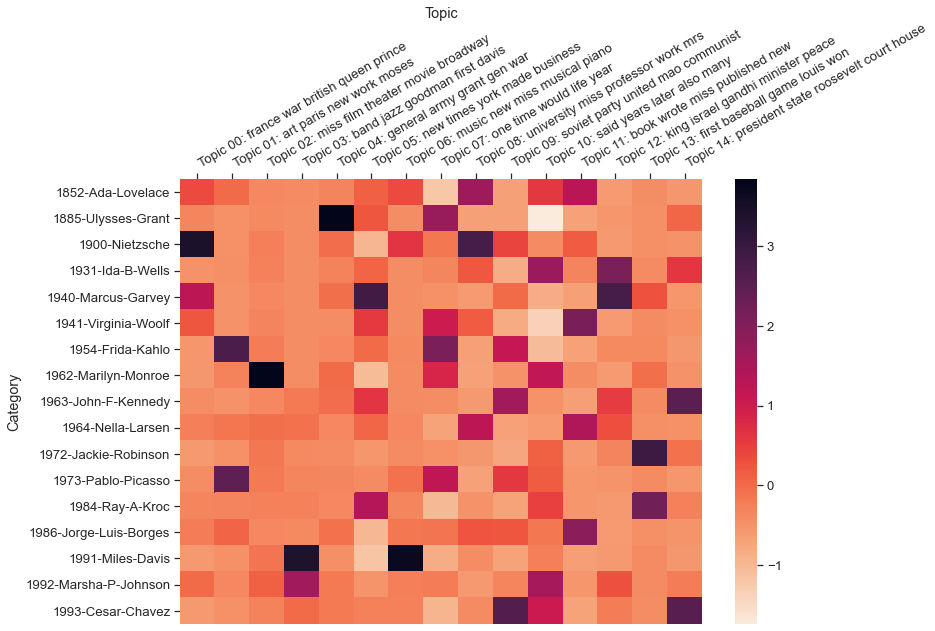

In [35]:
little_mallet_wrapper.plot_categories_by_topics_heatmap(obit_titles,
                                      topic_distributions,
                                      topics, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )

The darker squares in this heatmap represent a high probability for the corresponding topic (compared to everyone else in the heatmap) and the lighter squares in the heatmap represent a low probability for the corresponding topic. For example, if you scan across the row of Marilyn Monroe, you can see a dark square for the topic "miss film theater movie theater broadway". If you scan across the row of Ada Lovelace, an English mathematician who is now recognized as the first computer programmer, according to her [NYT obituary](https://www.nytimes.com/interactive/2018/obituaries/overlooked-ada-lovelace.html), you can see a dark square for "university professor research science also".

The `plot_categories_by_topics_heatmap()` function also helpfully outputs a PDF of the heatmap to `output_directory_path + '/categories_by_topics.pdf'`. We can download this PDF and explore it in more detail or embed it in an article or blog post!

In [1]:
from IPython.display import IFrame
IFrame("topic-model-output/NYT-obits/categories_by_topics.pdf", width=1000, height=600)

## Display Top Titles Per Topic

We can also display the obituaries that have the highest probability for every topic with the `little_mallet_wrapper.get_top_docs()` function.

Because most of the obituaries in our corpus are pretty long, however, it will be more useful for us to simply display the title of each obituary, rather than the entire document—at least as a first step. To do so, we'll first need to make two dictionaries, which will allow us to find the corresponding obituary title and the original text from a given training document.

In [399]:
training_data_obit_titles = dict(zip(training_data, obit_titles))
training_data_original_text = dict(zip(training_data, original_texts))

Then we'll make our own function `display_top_titles_per_topic()` that will display the top text titles for every topic. This function accepts a given `topic_number` as well as a desired `number_of_documents` to display.

In [567]:
def display_top_titles_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), training_data_obit_titles[document] + "\n")
    return

**Topic 0**

To display the top 5 obituary titles with the highest probability of containing Topic 0, we will run:

In [568]:
display_top_titles_per_topic(topic_number=0, number_of_documents=5)

✨Topic 0✨

['miss', 'film', 'theater', 'movie', 'broadway', 'films', 'stage', 'hollywood', 'movies', 'actor', 'made', 'television', 'director', 'new', 'show', 'role', 'won', 'actress', 'first', 'york']

0.5313 1996-Gene-Kelly

0.5093 1992-Shirley-Booth

0.4752 1995-Ginger-Rogers

0.4707 1990-Rex-Harrison

0.457 1987-Rita-Hayworth



**Topic 0 Label**: 

Hollywood (Double-click this cell to enter your own label)

**Topic 9**

To display the top 5 obituary titles with the highest probability of containing Topic 9, we will run:

In [582]:
display_top_titles_per_topic(topic_number=9, number_of_documents=5)

✨Topic 9✨

['israel', 'peace', 'war', 'minister', 'united', 'nations', 'king', 'secretary', 'arab', 'states', 'churchill', 'british', 'jewish', 'israeli', 'prime', 'dulles', 'sadat', 'state', 'foreign', 'later']

0.4148 1992-Menachem-Begin

0.4099 1999-King-Hussein

0.3448 1995-Yitzhak-Rabin

0.3295 1981-Anwar-el-Sadat

0.3288 1952-Chaim-Weizmann



**Topic 9 Label**: 

Global Affairs (Double-click this cell to enter your own label)

**Topic 8**

To display the top 7 obituaries with the highest probability of containing Topic 8, we will run:

In [565]:
display_top_titles_per_topic(topic_number=8, number_of_documents=7)

✨Topic 8✨

['miss', 'book', 'new', 'wrote', 'published', 'mrs', 'writing', 'life', 'writer', 'years', 'books', 'said', 'author', 'york', 'story', 'novel', 'women', 'magazine', 'work', 'later']

0.429 1941-James-Joyce

0.4267 1936-Anne-Macy

0.4151 1967-Langston-Hughes

0.413 1978-Bruce-Catton

0.403 1964-Nella-Larsen

0.3998 1909-Sarah-Orne-Jewett

0.398 1992-Alex-Haley



**Topic 8 Label**: 

Authors (Double-click this cell to enter your own label)

## Display Topic Words in Context of Original Text

Often it's useful to actually look at the document that has ranked highly for a given topic and puzzle out why it ranks so highly.

To display the original obituary texts that rank highly for a given topic, with the relevant topic words **bolded** for emphasis, we are going to make the function `display_bolded_topic_words_in_context()`.

In the cell below, we're importing two special Jupyter notebook display modules, which will allow us to make the relevant topic words **bolded**, as well as the regular expressions library `re`, which will allow us to find and replace the correct words.

In [584]:
from IPython.display import Markdown, display
import re

def display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3, custom_words=None):

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        
        print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")
        
        probability = f"✨✨✨\n\n**{probability}**"
        obit_title = f"**{training_data_obit_titles[document]}**"
        original_text = training_data_original_text[document]
        topic_words = topics[topic_number]
        topic_words = custom_words if custom_words != None else topic_words

        for word in topic_words:
            if word in original_text:
                original_text = re.sub(f"\\b{word}\\b", f"**{word}**", original_text)

        display(Markdown(probability)), display(Markdown(obit_title)), display(Markdown(original_text))
    return

**Topic 3**

To display the top 3 original obituaries with the highest probability of containing Topic 0 and with relevant topic words bolded, we will run:

In [587]:
display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3)

✨Topic 3✨

['said', 'one', 'years', 'man', 'also', 'never', 'could', 'many', 'like', 'even', 'called', 'life', 'people', 'would', 'well', 'wrote', 'way', 'another', 'took', 'old']



✨✨✨

**0.43772609819121444**

**1962-Marilyn-Monroe**

August 6, 1962

OBITUARY

Brilliant Stardom and Personal Tragedy Punctuated the Life of Marilyn Monroe

By THE NEW YORK TIMES

The **life** of Marilyn Monroe, the golden girl of the movies, ended as it began, in misery and tragedy.

Her death at the age of 36 closed an incredibly glamorous career and capped a series of somber events that began with her birth as an unwanted, illegitimate baby and went on and on, illuminated during

the last dozen **years** by the lightning of fame.

Her public **life** was in dazzling contrast to her private **life**.

The first **man** to see her on the screen, the **man** who made her screen test, felt the almost universal reaction as he ran the wordless scene. In it, she walked, sat down and lit a cigarette.

Recalled 'Lush Stars'

"I got a cold chill," he **said**. "This girl had something I hadn't seen since silent pictures. This is the first girl who looked **like** **one** of those lush stars of the silent era. Every

frame of the test radiated sex."

Billy Wilder, the director, **called** it "flesh impact."

"Flesh impact is rare," he **said**. "Three I remember who had it were Clara Bow, Jean Harlow and Rita Hayworth. Such girls have flesh which photographs **like** flesh. You feel you can reach

out and touch it."

Fans paid $200,000,000 to see her project this quality. No sex symbol of the era other than Brigitte Bardot **could** match her popularity. Toward the end, she **also** convinced critics and the public that

she **could** act.

During the **years** of her greatest success, she saw two of her marriages end in divorce. She suffered at least two miscarriages and was **never** able to have a child. Her emotional insecurity deepened; her

**many** illnesses came upon her more frequently.

Dismissed From Picture

In 1961, she was twice admitted to hospitals in New York for psychiatric observation and rest. She was dismissed in June by Twentieth Century-Fox after being absent all but five days during seven weeks

of shooting "Something's Got to Give."

"It's something that Marilyn no longer can control," **one** of her studio chiefs confided. "Sure she's sick. She believes she's sick. She may **even** have a fever, but it's

a sickness of the mind. Only a psychiatrist can help her now."

In her last interview, published in the Aug. 3 issue of Life magazine, she told Richard Meryman, an associate editor:

"I was **never** used to being happy, so that wasn't something I ever **took** for granted."

Considering her background, this was a statement of exquisite restraint.

She was born in Los Angeles on June 1, 1926. The name on the birth record is Norma Jean Mortenson, the surname of the **man** who fathered her, then abandoned her mother. She later **took** her mother's last name, Baker.

Family Tragedies

Both her maternal grandparents and her mother were committed to mental institutions. Her uncle killed himself. Her father died in a motorcycle accident three **years** after her birth.

Her childhood has been described as "Oliver Twist in girl's clothing."

During her mother's stays in asylums, she was farmed out to twelve sets of foster parents. Two families were religious fanatics; **one** gave her empty whisky bottles to play with instead of dolls.

At **another** stage, she lived in a drought area with a family of seven. She spent two **years** in a Los Angeles orphanage, wearing a uniform she detested.

By the time she was 9 **years** **old**, Norma Jean had begun to stammer--an affliction rare among females.

Her dream since childhood had been to be a movie star, and she succeeded beyond her wildest imaginings. The conviction of her mother's best friend was borne out; she had told the little girl, day

after day:

"Don't worry. You're going to be a beautiful girl when you get big. You're going to be a movie star. Oh, I feel it in my bones."

Nunnally Johnson, the producer and writer, understood that Miss Monroe was something special. Marilyn, he **said**, was "a phenomenon of nature, **like** Niagara Falls and the Grand Canyon.

"You can't talk to it. It can't talk to you. All you can do is stand back and be awed by it," he **said**.

This figure in the minds of millions was difficult to analyze statistically. Her dimensions--37-23- 37--were voluptuous but not extraordinary. She stood 5 feet 5 1/2 inches tall. She had soft blonde

hair, wide, dreamy, gray-blue eyes. She spoke in a high baby voice that was little more than a breathless whisper.

Heavy Fan Mail

Fans **wrote** her 5,000 letters a week, at least a dozen of them proposing marriage. The Communists denounced her as a capitalist trick to make the American **people** forget how miserable they were. In Turkey

a young **man** **took** leave of his senses while watching "How to Marry a Millionaire" and slashed his wrists.

There were other symbols of success. She married two American male idols--**one** an athlete, **one** an intellectual.

Her second husband was Joe DiMaggio, the baseball player. Her third and last was the Pulitzer- Prize winning playwright, Arthur Miller.

She was 16 when she married for the first time. The bridegroom was James Dougherty, 21, an aircraft worker.

Mr. Dougherty **said** after their divorce four **years** later, in 1946, that she had been a "wonderful" housekeeper.

Her two successive divorces came in 1954, when she split with Mr. DiMaggio after only nine months, and in 1960, after a four-year marriage to Mr. Miller.

She became famous with her first featured role of any prominence in "The Asphalt Jungle," issued in 1950.

Her appearance was brief but unforgettable. From the instant she moved onto the screen with that extraordinary walk of hers, **people** asked themselves: "Who's that blonde?"

In 1952 it was revealed that Miss Monroe had been the subject of a widely distributed nude calendar photograph shot while she was a notably unsuccessful starlet.

Revealed Her Wit

It created a scandal, but it was her reaction to the scandal that was remembered. She told interviewers that she was not ashamed and had needed the money to pay her rent.

She **also** revealed her sense of humor. When asked by a woman journalist, "You mean you didn't have anything on?" she replied breathlessly:

"Oh yes, I had the radio on."

One of her most exasperating quirks was her tardiness. She was, during the **years** of her fame, anywhere from **one** to twenty-four hours late for appointments. Until lately, she managed to get away with

it.

Her dilatory nature and sicknesses added nearly $1,000,000 to the budget of "Let's Make Love." The late Jerry Wald, head of her studio, simply commented:

"True, she's not punctual. She can't help it, but I'm not sad about it," he **said**, "I can get a dozen beautiful blondes who will show up promptly in make-up at 4 A.M. each

morning, but they are not Marilyn Monroe."

The tardiness, the lack of responsibility and the fears began to show more and more through the glamorous patina as Miss Monroe's career waxed.

Speaking of her career and her fame in the Life interview, she **said**, wistfully:

"It might be kind of a relief to be finished. It's sort of **like** I don't know what kind of a yard dash you're running, but then you're at the finish line and you sort of sigh--you've

made it! But you **never** have--you have to start all over again."



**Topic 8**

To display the top 3 original obituaries with the highest probability of containing Topic 8 and with relevant topic words bolded, we will run:

In [586]:
display_bolded_topic_words_in_context(topic_number=8, number_of_documents=3)

✨Topic 8✨

['miss', 'book', 'new', 'wrote', 'published', 'mrs', 'writing', 'life', 'writer', 'years', 'books', 'said', 'author', 'york', 'story', 'novel', 'women', 'magazine', 'work', 'later']



✨✨✨

**0.42896497441951986**

**1941-James-Joyce**

January 13, 1941

OBITUARY

James Joyce Dies; Wrote 'Ulysses'

By THE NEW YORK TIMES

ZURICH, Switzerland, Monday, Jan 13- James Joyce, Irish **author** whose "Ulysses" was the center of one of the most bitter literary controversies of modern times, died in a hospital here early

today despite the efforts of doctors to save him by blood transfusions. He would have been 59 **years** old Feb. 2.

Joyce underwent an intestinal operation Saturday afternoon at the Schwesternhaus von Rotenkreuz Hospital. For a time he appeared to be recovering. Only yesterday his son reported him to have been cheerful and apparently out of danger.

During the afternoon, however, the **writer** suffered a sudden relapse and sank rapidly. He died at 2:15 A.M. (8:15 P.M., Eastern standard time).

His wife and son were at the hospital when he died.

Hailed and Belittled by Critics

The status of James Joyce as a **writer** never could be determined in his lifetime. In the opinion of some critics, notably Edmund Wilson, he deserved to rank with the great innovators of literature as one whose influence upon other writers of his time was

incalculable. On the other hand, there were critics like Max Eastman who gave him a place with Gertrude Stein and T.S. Eliot among the "Unintelligibles" and there was Professor Irving Babbitt

of Harvard who dismissed his most widely read **novel**, "Ulysses," as one which only could have been written "in an advanced stage of psychic disintegration."

Originally **published** in 1922, "Ulysses" was not legally available in the United States until eleven **years** **later**, when United States Judge John Monro Woolsey handed down his famous decision to the effect that the **book** was not obscene. Hitherto

the **book** had been smuggled in and sold at high prices by "bookleggers" and a violent critical battle had raged around it.

Judge Woolsey's Decision

"'Ulysses' is not an easy **book** to read or understand," Judge Woolsey **wrote**. "But there has been much written about it, and in order properly to approach the consideration of it it is advisable to read a number of other **books** which

have now become its satellites. The study of "Ulysses" is therefore a heavy task.

"The reputation of 'Ulysses' in the literary world, however, warranted my taking such time as was necessary to enable me to satisfy myself as to the intent with which the **book** was written, for, of course, in any case where a **book** is claimed

to be obscene it must first be determined whether the intent with which it was written was what is called, according to the usual phrase, pornographic, that is, written for the purpose of exploiting

obscenity.

"If the conclusion is that the **book** is pornographic that is the end of the inquiry... But in 'Ulysses," in spite of its unusual frankness, I do not detect anywhere the leer of the sensualist. I hold, therefore, that it is not pornographic."

On the passages dealing with sex, Judge Woolsey paused to remark that the reader must not forget that "the characters are Celtic and the time is Spring." His decision was hailed as one of the most civilized ever propounded by an American judge.

After he had admitted Ulysses to the country, there was a rush to but the almost immediately available authorized and uncensored edition **published** by Random House. Since then the **book**, unlike many

another once banned by the censor and then forgotten, has been read widely; less for the passages once objected to than for the **book** as a whole.

Although Joyce appeared in many of his writings, "notably "A Portrait of the Artist as a Young Man" and "Ulysses," as Stephen Dedalus, many details of his **life** are missing. The most comprehensive study is Herbert Gorman's

biography **published** in 1940.

Was Born in Dublin

The **writer** was born Feb. 2, 1882, in Dublin, Ireland, the son of John Stanislaus Joyce (The Simon Dedalus of "Ulysses" whom Bloom hears singing in the Ormond bar) and Mary Murray Joyce. His father supposedly had one of the finest tenor voices

in Ireland. James Joyce had an equally fine voice.

The Joyce family was not prosperous and it was large. James stood out among his brothers and sisters and, at the age of 9, is supposed to have written an attack on Tim Healy, the anti-Parnellite, which was printed but of which no known copy exists. Since

he was literary it was decided to give him an education and he was sent first to Clongowes Wood College, then to Belvedere College, also in Ireland, and **later** he received his Bachelor of Arts degree

from the Royal University in Dublin.

He was an amazing scholar, and an independent and solitary figure. When he was 17 he read Ibsen's plays and **wrote** an essay for the Fortnightly Review about the **author** of "The Doll's House." Dissatisfied with the English translations,

Joyce learned Norwegian when he was 19 **years** old so that he might read his literary god in the original. At the same time he was reading and studying Dante, all the Elizabethan poets, St. Thomas

Aquinas and Aristotle.

In those days, according to Padraic Colum, who knew him at the Royal University (**later** reorganized as the National University), Joyce was a tall, slender young man with "a Dantesque face and steely blue eyes," who sauntered along the street

in a peaked tennis cap, soiled tennis shoes, carrying an ashplant for a cane. Stephen Dedalus carries a similar cane in "Ulysses" and frequently talks with it! He loved to sing and recite

poetry in his fine tenor voice, but he spoke harshly and used "many of the unprintable words he got printed in 'Ulysses.'"

Conceit and arrogance were his characteristics. When he first met Yeats he remarked:

"We have met too late; you are too old to be influenced by me."

AE (George Russell) recognized his "keen and cold intelligence," but told the young man, "I'm afraid you have not enough chaos in you to make a world."

Joyce was in continuous rebellion against Ireland and its **life** and **said**: "When the soul of a man is born in this country there are no nets flung at it to hold it back from flight."

The words are Stephen Dedalus's in "A Portrait of the Artist as a Young Man," but it was Joyce speaking, and, at the age of 20, he left Ireland for Paris where he intended, and for a time pretended, to study medicine.

At this time he started the stories that were eventually **published** as "Dubliners" (this **book** was **later** publicly burned in a Dublin public square) and started his first **novel**. This, the "Portrait of the Artist," was ten **years** in the

**writing**. His first **published** **work**- except for the forgotten attack on Tim Healy- was "Chamber Music," a collection of Elizabethan-like verse, which were printed in 1907.

It was at this time that he met Nora Barnacle, "a sleek blond beauty" from Galway, the daughter of Thomas and Ann Healy Barnacle. They soon went to the continent to live (their marriage was not regularized until twenty-seven **years** **later**, when

they visited a London registry office to legalize the status of their two children, George and Lucia). In Trieste, where they settled after some wandering, Joyce taught English at the Berlitz School

and the Commercial Academy. He knew seventeen languages, ancient and modern, including Arabic, Sanskrit and Greek.

"Dubliners" Issued in 1914

In 1914 Dubliners was **published** in London. In the same year he also finished his **novel** "Portrait of the Artist as a Young Man."

When war was declared Joyce and his wife, who were British citizens, were in Austria. He was forced out of his job as a teacher, and the couple moved to Zurich.

While living in Zurich Joyce began to suffer from severe ocular illness and eventually underwent at least ten operations on his eyes. For **years** he was almost totally blind and much of his **later** **writing** was done with red crayon on huge white sheets of

paper.

"Ulysses" was begun under this difficult situation. Much of it was **published** by Margaret Anderson in The Little Review, the **magazine** which Otto Kahn, New York banker, once subsidized for his Greenwich Village friends. Chapters appeared between

March, 1918, and August, 1920, when the Society for the Suppression of Vice had The Review stopped by court order.

After the war the Joyces returned to Trieste, where they lived with Stanislaus Joyce, the **author**'s brother. Then, in 1919, they went to Paris, where they made their home until the next war sent them again to Zurich to occupy the house they had known

in 1914.

In 1922 Joyce's greatest **book**, "Ulysses," was **published** in Paris. Great Britain, Ireland and the United States banned the **book**.

For many **years** after "Ulysses" was done Joyce worked on what he called "Work in Progress." Much of it appeared in Transition, the **magazine** **published** in the Nineteen Twenties in Paris by Eugene Jolas. In May, 1939, it was **published**

as "Finnegan's Wake," a **book** "distinguished" by such "words" as Goragorridgeorballyedpuhkalsom, to name one of the simpler ones, and many puns. In it Mr. Joyce

suggested the **book** was the **work** of "a too pained whitelwit laden with the loot of learning."

During all his **years** as a **writer** Joyce was carefully protected by his wife, who once **said** she cared for him despite "his necessity to write those **books** no one can understand." His conversation was clear, never anything like his **writing**, and

his wit as keen.

Joyce's son, George Joyce, married the former Miss Helen Castor of Long Branch, N.J. They had one son, Stephen James Joyce. James Joyce and his wife made their home with his son for many **years** before the present war.



## Your Turn!

Choose a topic from the results above and write down its corresponding topic number below.

**Topic: *Your Number Choice Here***

**1.** Display the top 6 obituary titles for this topic.

In [554]:
#Your Code Here

**2.** Display the topic words in the context of the original obituary for these 6 top titles.

In [554]:
#Your Code Here

**3.** Come up with a label for your topic and write it below:

**Topic Label: *Your Label Here***

**Reflection**

**4.** Why did you label your topic the way you did? What do you think this topic means in the context of all the *NYT* obituaries?

**#**Your answer here

**5.** What's another collection of texts that you think might be interesting to topic model? Why?

**#**Your answer here